## DATASET

In [ ]:
import numpy as np
from tensorflow.keras.datasets import mnist, fashion_mnist
import matplotlib.pyplot as plt

Loading the MNIST and Fashion MNIST dataset

In [ ]:
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()
(fashion_mnist_x_train, fashion_mnist_y_train), (fashion_mnist_x_test, fashion_mnist_y_test) = fashion_mnist.load_data()
print()

print('Shape MNIST train:', np.shape(mnist_x_train))
print('Shape Fashion MNIST train:', np.shape(fashion_mnist_x_train))
print()

# Normalization and Padding
mnist_x_train = np.pad(mnist_x_train,((0,0),(2,2),(2,2)))/255.
mnist_x_test = np.pad(mnist_x_test,((0,0),(2,2),(2,2)))/255.
print('Shape MNIST train after padding:', np.shape(mnist_x_train))
fashion_mnist_x_train = np.pad(fashion_mnist_x_train,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_test = np.pad(fashion_mnist_x_test,((0,0),(2,2),(2,2)))/255.
print('Shape Fashion MNIST train after padding:', np.shape(mnist_x_train))


Shape MNIST train: (60000, 28, 28)
Shape Fashion MNIST train: (60000, 28, 28)

Shape MNIST train after padding: (60000, 32, 32)
Shape Fashion MNIST train after padding: (60000, 32, 32)


In [ ]:
print(f'Number of MNIST/fashion MNIST training samples: {np.shape(mnist_x_train)[0]}')
print(f'Number of MNIST/fashion MNIST test samples: {np.shape(mnist_x_test)[0]}')
print(f'MNIST/fashion MNIST resolution: {np.shape(mnist_x_test)[1:]}')

Number of MNIST/fashion MNIST training samples: 60000
Number of MNIST/fashion MNIST test samples: 10000
MNIST/fashion MNIST resolution: (32, 32)


Only one channel (grey-scale images).

In [ ]:
N_train, h, w = mnist_x_train.shape[0], mnist_x_train.shape[1], mnist_x_train.shape[2]
N_test = mnist_x_test.shape[0]

### Data generator
Generator which generates batches. A batch is a couple `x_batch, y_batch`, containing `batchsize` number of samples. `x_batch` represents the input, and it contains images `x`: each image `x` has spatial dimensions $32*32$ and it contains a pair of MNIST-fashion MNIST images added together. `y_batch` represents the ground truth, and it contains the images `y`: each image `y` has spatial dimensions $32*64$ and it contains the same pair of MNIST-fashion MNIST images concatenated along the width.

In [ ]:
def datagenerator(x1, x2, batchsize):
    # x1: first dataset of images. In our case, MNIST dataset (either train or test)
    # x2: second dataset of images. In our case, fashion MNIST dataset (either train or test)

    n1 = x1.shape[0]
    n2 = x2.shape[0]
    while True:
        num1 = np.random.randint(0, n1, batchsize)
        num2 = np.random.randint(0, n2, batchsize)

        x_batch = (x1[num1] + x2[num2]) / 2.0
        y_batch = np.concatenate((x1[num1], x2[num2]), axis=2)

        yield x_batch, y_batch 

In [ ]:
batchsize = 64

In [ ]:
# Generator for creating the training batches
train_generator = datagenerator(mnist_x_train, fashion_mnist_x_train, batchsize)

# Generator for creating the validation batches
test_generator = datagenerator(mnist_x_test, fashion_mnist_x_test, batchsize)

Example of a training batch

In [ ]:
x_batch, y_batch = next(train_generator)
print('Shape of the x_batch:', x_batch.shape)
print('Shape of the y_batch:', y_batch.shape)

Shape of the x_batch: (64, 32, 32)
Shape of the y_batch: (64, 32, 64)


The data is already normalized into $[0,1]$

In [ ]:
x_batch[0].min(), x_batch[0].max()

(0.0, 0.8313725490196078)

In [ ]:
y_batch[0].min(), y_batch[0].max()

(0.0, 1.0)

Visualization of a sample in the batch

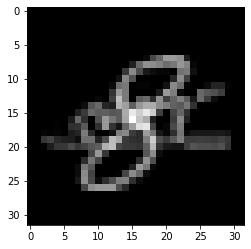

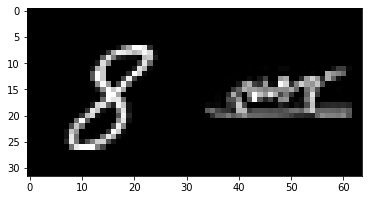

In [ ]:
x = x_batch[0]  # Input
y = y_batch[0]  # Ground truth
plt.imshow(x,cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(y, cmap='gray', interpolation='nearest')
plt.show()

## MODEL
U-Net (i.e. fully convolutional autoencoder with skip connections). One single encoder, and two decoder: one for producing the MNIST image, and one for producing the fashion MNIST image. Input: $32*32*1$. Two outputs $32*32*1$, which are concatenated together along the width, producing a single output $32*64*1$. U-net with two branches.

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, ReLU, MaxPool2D, concatenate, Concatenate
from tensorflow.keras import Model

In [ ]:
def build_unet(input_shape, n_ch=32, L=4, conv_per_L=2):
    x = Input(shape=input_shape)

    # ENCODER
    backup_layers1 = []  # Encoding layers, for the skip connections for the first decoder
    backup_layers2 = []  # Encoding layers, for the skip connections for the second decoder
    h = x
    for l in range(L):

        # Each floor in the descent phase
        for c in range(conv_per_L):
            h = Conv2D(n_ch, 3, 1, padding='same')(h)
            h = ReLU()(h)

        if l < L-1: # We don't want to downsample at the last level
            # Downsample
            # Save the encoding layer for the skip connection 
            backup_layers1.append(h)
            backup_layers2.append(h)
            h = MaxPool2D(padding='same')(h)

            # Update the channels
            n_ch = n_ch * 2

    h1 = h  # For the first decoder
    h2 = h  # For the second decoder

    n_ch1 = n_ch  # For the first decoder
    n_ch2 = n_ch  # For the second decoder
   
    # FIRST DECODER, for producing the MNIST digit
    # (pay attention to do not double count the last level)
    for l in range(L-1):
        # Reduce the channels
        n_ch1 = n_ch1 // 2

        # Upsample
        h1 = Conv2DTranspose(n_ch1, 3, 2, padding='same')(h1)

        # Concatenate
        h1 = concatenate([h1, backup_layers1.pop(-1)])

        # Each floor in the up phase
        for c in range(conv_per_L):
            h1 = Conv2D(n_ch1, 3, 1, padding='same')(h1)
            h1 = ReLU()(h1)

    # MNIST image: 32*32*1
    x1 = Conv2D(1, 1, activation='sigmoid', name='x1')(h1)

    # SECOND DECODER, for producing the fashion MNIST digit
    # (pay attention to do not double count the last level)
    for l in range(L-1):
        # Reduce the channels
        n_ch2 = n_ch2 // 2

        # Upsample
        h2 = Conv2DTranspose(n_ch2, 3, 2, padding='same')(h2)

        # Concatenate
        h2 = concatenate([h2, backup_layers2.pop(-1)])

        # Each floor in the up phase
        for c in range(conv_per_L):
            h2 = Conv2D(n_ch2, 3, 1, padding='same')(h2)
            h2 = ReLU()(h2)
        
    # Fashion MNIST image: 32*32*1
    x2 = Conv2D(1, 1, activation='sigmoid', name='x2')(h2)

    # Final output: 32*64*1
    y = Concatenate(axis=2)([x1,x2])

    return Model(x, y)

In [ ]:
unet = build_unet((32, 32, 1), n_ch=16, L=2, conv_per_L=2)

In [ ]:
unet.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d_72 (Conv2D)             (None, 32, 32, 16)   160         ['input_9[0][0]']                
                                                                                                  
 re_lu_60 (ReLU)                (None, 32, 32, 16)   0           ['conv2d_72[0][0]']              
                                                                                                  
 conv2d_73 (Conv2D)             (None, 32, 32, 16)   2320        ['re_lu_60[0][0]']               
                                                                                            

$40k$ parameters.

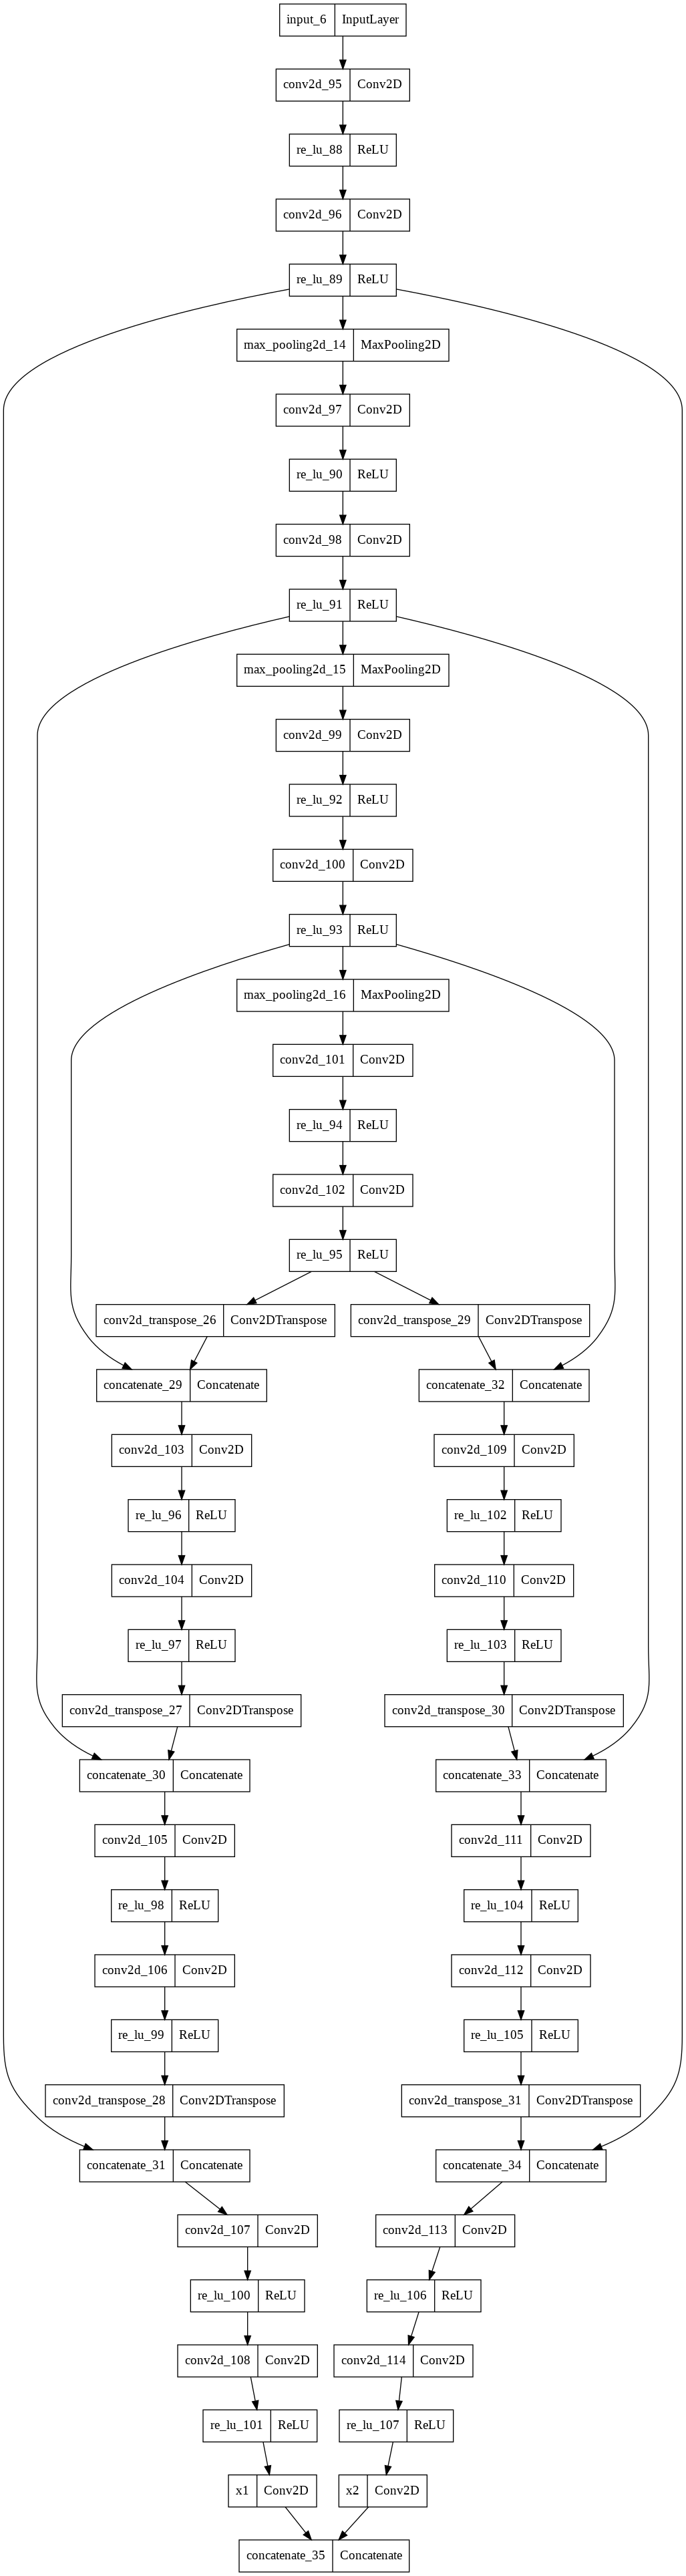

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(unet)

In [ ]:
from tensorflow.keras.optimizers import Adam

In [ ]:
unet.compile(optimizer=Adam(), loss='mse')

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', min_lr=0.000009, min_delta=0.0001, factor=0.75, patience=3, verbose=1, mode='min')
reduce_lr_callback = ReduceLROnPlateau(patience=3, min_delta=0.00001)

callback_checkpoint = ModelCheckpoint('UNET_branches.{epoch:02d}-{val_loss:.4f}.hdf5', save_weights_only=True) 

In [ ]:
steps_per_epoch = 5000
val_steps = N_test // batchsize

In [ ]:
hist = unet.fit(train_generator, epochs=50, batch_size=batchsize, validation_data=test_generator, callbacks=[callback_checkpoint,reduce_lr_callback],
              steps_per_epoch=steps_per_epoch, validation_steps=val_steps)

Epoch 1/50
5000/5000 [==============================] - 60s 12ms/step - loss: 0.0116 - val_loss: 0.0024 - lr: 0.0010
Epoch 2/50
5000/5000 [==============================] - 59s 12ms/step - loss: 0.0021 - val_loss: 0.0018 - lr: 0.0010
Epoch 3/50
5000/5000 [==============================] - 59s 12ms/step - loss: 0.0017 - val_loss: 0.0016 - lr: 0.0010
Epoch 4/50
5000/5000 [==============================] - 58s 12ms/step - loss: 0.0015 - val_loss: 0.0015 - lr: 0.0010
Epoch 5/50
5000/5000 [==============================] - 59s 12ms/step - loss: 0.0014 - val_loss: 0.0013 - lr: 0.0010
Epoch 6/50
5000/5000 [==============================] - 59s 12ms/step - loss: 0.0013 - val_loss: 0.0013 - lr: 0.0010
Epoch 7/50
5000/5000 [==============================] - 59s 12ms/step - loss: 0.0012 - val_loss: 0.0012 - lr: 0.0010
Epoch 8/50
5000/5000 [==============================] - 58s 12ms/step - loss: 0.0012 - val_loss: 0.0012 - lr: 0.0010
Epoch 9/50
5000/5000 [==============================] - 58s 12ms

In [ ]:
hist = unet.fit(train_generator, epochs=15, batch_size=batchsize, validation_data=test_generator, callbacks=[callback_checkpoint],
              steps_per_epoch=steps_per_epoch, validation_steps=val_steps)

Epoch 1/15
10000/10000 [==============================] - 118s 12ms/step - loss: 0.0137 - val_loss: 0.0018
Epoch 2/15
10000/10000 [==============================] - 117s 12ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 3/15
10000/10000 [==============================] - 116s 12ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 4/15
10000/10000 [==============================] - 114s 11ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 5/15
10000/10000 [==============================] - 114s 11ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 6/15
10000/10000 [==============================] - 115s 11ms/step - loss: 0.0010 - val_loss: 9.8043e-04
Epoch 7/15
10000/10000 [==============================] - 114s 11ms/step - loss: 9.8177e-04 - val_loss: 0.0010
Epoch 8/15
10000/10000 [==============================] - 114s 11ms/step - loss: 9.5314e-04 - val_loss: 9.2407e-04
Epoch 9/15
10000/10000 [==============================] - 114s 11ms/step - loss: 9.2446e-04 - val_loss: 8.9519e-04
Epoch 10/15
1

In [ ]:
test_generator1 = datagenerator(mnist_x_test, fashion_mnist_x_test, 20000)
mse_list = []
for i in range(10):
  x_batch, y_batch = next(test_generator1)
  mse = unet.evaluate(x_batch, y_batch)
  mse_list.append(mse)
print(mse_list)
print('Min:', np.min(mse_list))
print('Mean:', np.mean(mse_list))
print('Std:', np.std(mse_list))

2/2 [==============================] - 0s 7ms/step - loss: 7.7875e-04
[0.0009212492732331157, 0.0008543870644643903, 0.0006754649220965803, 0.0008577097905799747, 0.0008252267143689096, 0.0009473353857174516, 0.001074432977475226, 0.0009210568969137967, 0.000891397416125983, 0.0007787547074258327]
0.000874701514840126
0.00010090231214073166


Min score: $0.000675$. Mean score: $0.00087$. Std: $0.0001$.

**Better scores than before!!!**

In [ ]:
import matplotlib.pyplot as plt
def plot_history(training_history, n_epochs=None):
    if not n_epochs:
      n_epochs = len(training_history.history['loss'])

    epochs = range(1,n_epochs+1)

    plt.plot(epochs, training_history.history['loss'], label='train_loss')
    plt.plot(epochs, training_history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.title('Loss')

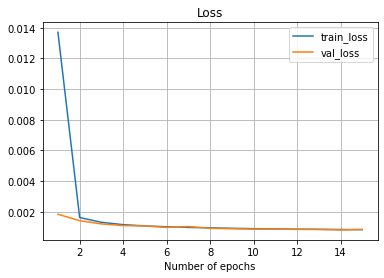

In [ ]:
plot_history(hist)

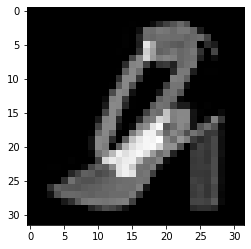

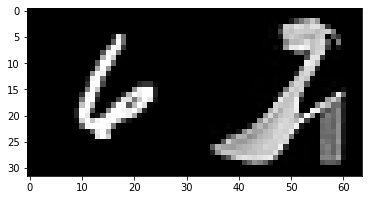

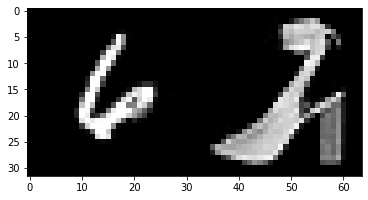

In [ ]:
x_batch, y_batch = next(test_generator)
x = x_batch[0]
y = y_batch[0]
y_pred = unet.predict(x.reshape((1,32,32)))
plt.imshow(x,cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(y, cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(y_pred[0].reshape((32,64)), cmap='gray', interpolation='nearest')
plt.show()

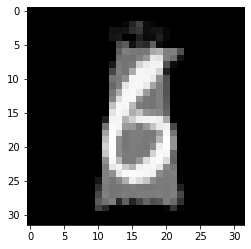

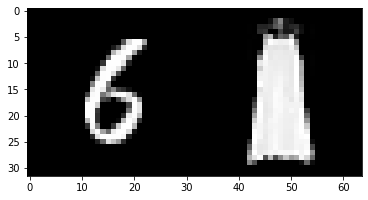

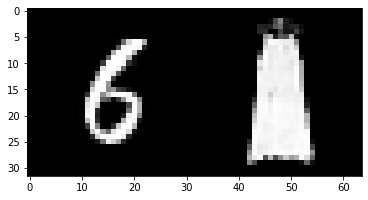

In [ ]:
x_batch, y_batch = next(test_generator)
x = x_batch[0]
y = y_batch[0]
y_pred = unet.predict(x.reshape((1,32,32)))
plt.imshow(x,cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(y, cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(y_pred[0].reshape((32,64)), cmap='gray', interpolation='nearest')
plt.show()

## MORE PARAMETERS

In [18]:
def build_unet(input_shape, n_ch=32, L=4, conv_per_L=2):
    x = Input(shape=input_shape)

    # DOWN
    #backup_layers = []
    backup_layers1 = []
    backup_layers2 = []
    h = x
    for l in range(L):

        # Each floor in the descent phase
        for c in range(conv_per_L):
            h = Conv2D(n_ch, 3, 1, padding='same')(h)
            h = ReLU()(h)

        if l < L-1: # We don't want to downsample at the last level
            # Downsample
            #backup_layers.append(h) # save for the skip connection 
            backup_layers1.append(h)
            backup_layers2.append(h)
            h = MaxPool2D(padding='same')(h)

            # Update the channels
            n_ch = n_ch * 2

    h1 = h#tf.identity(h)
    h2 = h#tf.identity(h)

    n_ch1 = n_ch
    n_ch2 = n_ch

    #backup_layers1 = [tf.identity(l) for l in backup_layers] #deepcopy(backup_layers) # backup_layers.deepcopy()
    #backup_layers2 = [tf.identity(l) for l in backup_layers] #deepcopy(backup_layers) # backup_layers.deepcopy()
    
    # UP (pay attention to do not double count the last level)
    for l in range(L-1):
        # Reduce the channels
        n_ch1 = n_ch1 // 2

        # Upsample
        h1 = Conv2DTranspose(n_ch1, 3, 2, padding='same')(h1)

        # Concatenate
        h1 = concatenate([h1, backup_layers1.pop(-1)])
        #h1 = concatenate([h1, backup_layers1[-l-2]])

        # Each floor in the up phase
        for c in range(conv_per_L):
            h1 = Conv2D(n_ch1, 3, 1, padding='same')(h1)
            h1 = ReLU()(h1)

    # Output
    x1 = Conv2D(1, 1, activation='sigmoid', name='x1')(h1)

    # UP (pay attention to do not double count the last level)
    for l in range(L-1):
        # Reduce the channels
        n_ch2 = n_ch2 // 2

        # Upsample
        h2 = Conv2DTranspose(n_ch2, 3, 2, padding='same')(h2)

        # Concatenate
        h2 = concatenate([h2, backup_layers2.pop(-1)])
        #h2 = concatenate([h1, backup_layers2[-l-2]])

        # Each floor in the up phase
        for c in range(conv_per_L):
            h2 = Conv2D(n_ch2, 3, 1, padding='same')(h2)
            h2 = ReLU()(h2)
        
    # Output
    x2 = Conv2D(1, 1, activation='sigmoid', name='x2')(h2)

    #y = concatenate([x1,x2], axis=2)
    y = Concatenate(axis=2)([x1,x2])

    return Model(x, y)

In [10]:
unet = build_unet((32, 32, 1), n_ch=32, L=2, conv_per_L=2)

In [12]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   320         ['input_1[0][0]']                
                                                                                                  
 re_lu (ReLU)                   (None, 32, 32, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 32)   9248        ['re_lu[0][0]']                  
                                                                                              

$157k$ parameters.

In [11]:
from tensorflow.keras.optimizers import Adam

In [12]:
optimizer = Adam()
unet.compile(optimizer=Adam(), loss='mse')

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
"""reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', min_lr=0.000009, min_delta=0.0001, factor=0.75, patience=3, verbose=1, mode='min')
reduce_lr_callback = ReduceLROnPlateau(patience=3, min_delta=0.00001)"""

callback_checkpoint = ModelCheckpoint('UNET_branches.{epoch:02d}-{val_loss:.4f}.hdf5', save_weights_only=True) 

In [16]:
steps_per_epoch = 20000
val_steps = N_test // batchsize

In [17]:
hist = unet.fit(train_generator, epochs=50, batch_size=batchsize, validation_data=test_generator, callbacks=[callback_checkpoint],
              steps_per_epoch=steps_per_epoch, validation_steps=val_steps)

Epoch 1/50
20000/20000 [==============================] - 392s 19ms/step - loss: 0.0127 - val_loss: 8.9112e-04
Epoch 2/50
20000/20000 [==============================] - 378s 19ms/step - loss: 8.0713e-04 - val_loss: 7.4865e-04
Epoch 3/50
20000/20000 [==============================] - 384s 19ms/step - loss: 7.0645e-04 - val_loss: 6.7163e-04
Epoch 4/50
20000/20000 [==============================] - 378s 19ms/step - loss: 6.6159e-04 - val_loss: 6.3446e-04
Epoch 5/50
20000/20000 [==============================] - 379s 19ms/step - loss: 6.3151e-04 - val_loss: 6.3203e-04
Epoch 6/50
20000/20000 [==============================] - 379s 19ms/step - loss: 6.1640e-04 - val_loss: 6.1576e-04
Epoch 7/50
20000/20000 [==============================] - 381s 19ms/step - loss: 6.0081e-04 - val_loss: 5.8409e-04
Epoch 8/50
20000/20000 [==============================] - 385s 19ms/step - loss: 5.9061e-04 - val_loss: 5.9122e-04
Epoch 9/50
20000/20000 [==============================] - 383s 19ms/step - loss: 5.8

KeyboardInterrupt: ignored

In [20]:
test_generator1 = datagenerator(mnist_x_test, fashion_mnist_x_test, 20000)
mse_list = []
for i in range(10):
  x_batch, y_batch = next(test_generator1)
  mse = unet.evaluate(x_batch, y_batch)
  mse_list.append(mse)
print(mse_list)
print('Mean:', np.mean(mse_list))
print('Std:', np.std(mse_list))

625/625 [==============================] - 3s 4ms/step - loss: 5.3598e-04
[0.0005392072489485145, 0.0005339308409020305, 0.0005296709714457393, 0.0005502159474417567, 0.0005412509781308472, 0.0005393237806856632, 0.000532841426320374, 0.0005271613481454551, 0.000540170120075345, 0.0005359844071790576]
Mean: 0.0005369757069274783
Std: 6.255448644709368e-06


In [21]:
print('Min:', min(mse_list))

Min: 0.0005271613481454551


Min: $5.3e-4$. Mean: $5.4e-4$. Std: $6.25e-6$.

**Better scores!**

More training, with also reduce learning rate on plateau.

In [29]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
#reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', min_lr=0.000009, min_delta=0.0001, factor=0.75, patience=3, verbose=1, mode='min')
reduce_lr_callback = ReduceLROnPlateau(patience=2, min_delta=0.00001)

callback_checkpoint = ModelCheckpoint('UNET_branches.{epoch:02d}-{val_loss:.4f}.hdf5', save_weights_only=True) 

In [30]:
steps_per_epoch = 20000
val_steps = N_test // batchsize

In [31]:
hist = unet.fit(train_generator, epochs=10, batch_size=batchsize, validation_data=test_generator, callbacks=[callback_checkpoint,reduce_lr_callback],
              steps_per_epoch=steps_per_epoch, validation_steps=val_steps)

Epoch 1/10
20000/20000 [==============================] - 381s 19ms/step - loss: 5.4203e-04 - val_loss: 5.5280e-04 - lr: 0.0010
Epoch 2/10
20000/20000 [==============================] - 380s 19ms/step - loss: 5.4164e-04 - val_loss: 5.3448e-04 - lr: 0.0010
Epoch 3/10
20000/20000 [==============================] - 382s 19ms/step - loss: 5.3723e-04 - val_loss: 5.6581e-04 - lr: 0.0010
Epoch 4/10
20000/20000 [==============================] - 381s 19ms/step - loss: 5.3483e-04 - val_loss: 5.3837e-04 - lr: 0.0010
Epoch 5/10
20000/20000 [==============================] - 382s 19ms/step - loss: 4.9611e-04 - val_loss: 4.9259e-04 - lr: 1.0000e-04
Epoch 6/10
20000/20000 [==============================] - 383s 19ms/step - loss: 4.9086e-04 - val_loss: 5.0511e-04 - lr: 1.0000e-04
Epoch 7/10
20000/20000 [==============================] - 382s 19ms/step - loss: 4.8953e-04 - val_loss: 4.9438e-04 - lr: 1.0000e-04
Epoch 8/10
20000/20000 [==============================] - 381s 19ms/step - loss: 4.8495e-04 

In [32]:
test_generator1 = datagenerator(mnist_x_test, fashion_mnist_x_test, 20000)
mse_list = []
for i in range(10):
  x_batch, y_batch = next(test_generator1)
  mse = unet.evaluate(x_batch, y_batch)
  mse_list.append(mse)
print(mse_list)
print('Min:', min(mse_list))
print('Mean:', np.mean(mse_list))
print('Std:', np.std(mse_list))

625/625 [==============================] - 3s 4ms/step - loss: 4.9712e-04
[0.0004890670534223318, 0.0004874894511885941, 0.0004909554263576865, 0.0004990824963897467, 0.000495844054967165, 0.0004960110527463257, 0.00048611126840114594, 0.00048653807607479393, 0.0004896760219708085, 0.0004971170565113425]
Min: 0.00048611126840114594
Mean: 0.0004917891958029941
Std: 4.546602556532512e-06


Min: $4.87e-4$. Mean: $4.9e-4$. Std: $4.55e-6$.

**Better scores!**

## MAKING THE NETWORK FURTHER MORE COMPLEX
Same issues seen in the last noebook: the digit is not learnt...

In [ ]:
unet.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d_75 (Conv2D)             (None, 32, 32, 32)   320         ['input_5[0][0]']                
                                                                                                  
 re_lu_68 (ReLU)                (None, 32, 32, 32)   0           ['conv2d_75[0][0]']              
                                                                                                  
 conv2d_76 (Conv2D)             (None, 32, 32, 32)   9248        ['re_lu_68[0][0]']               
                                                                                            

In [ ]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d_15 (Conv2D)             (None, 32, 32, 32)   320         ['input_2[0][0]']                
                                                                                                  
 re_lu_14 (ReLU)                (None, 32, 32, 32)   0           ['conv2d_15[0][0]']              
                                                                                                  
 conv2d_16 (Conv2D)             (None, 32, 32, 32)   9248        ['re_lu_14[0][0]']               
                                                                                              

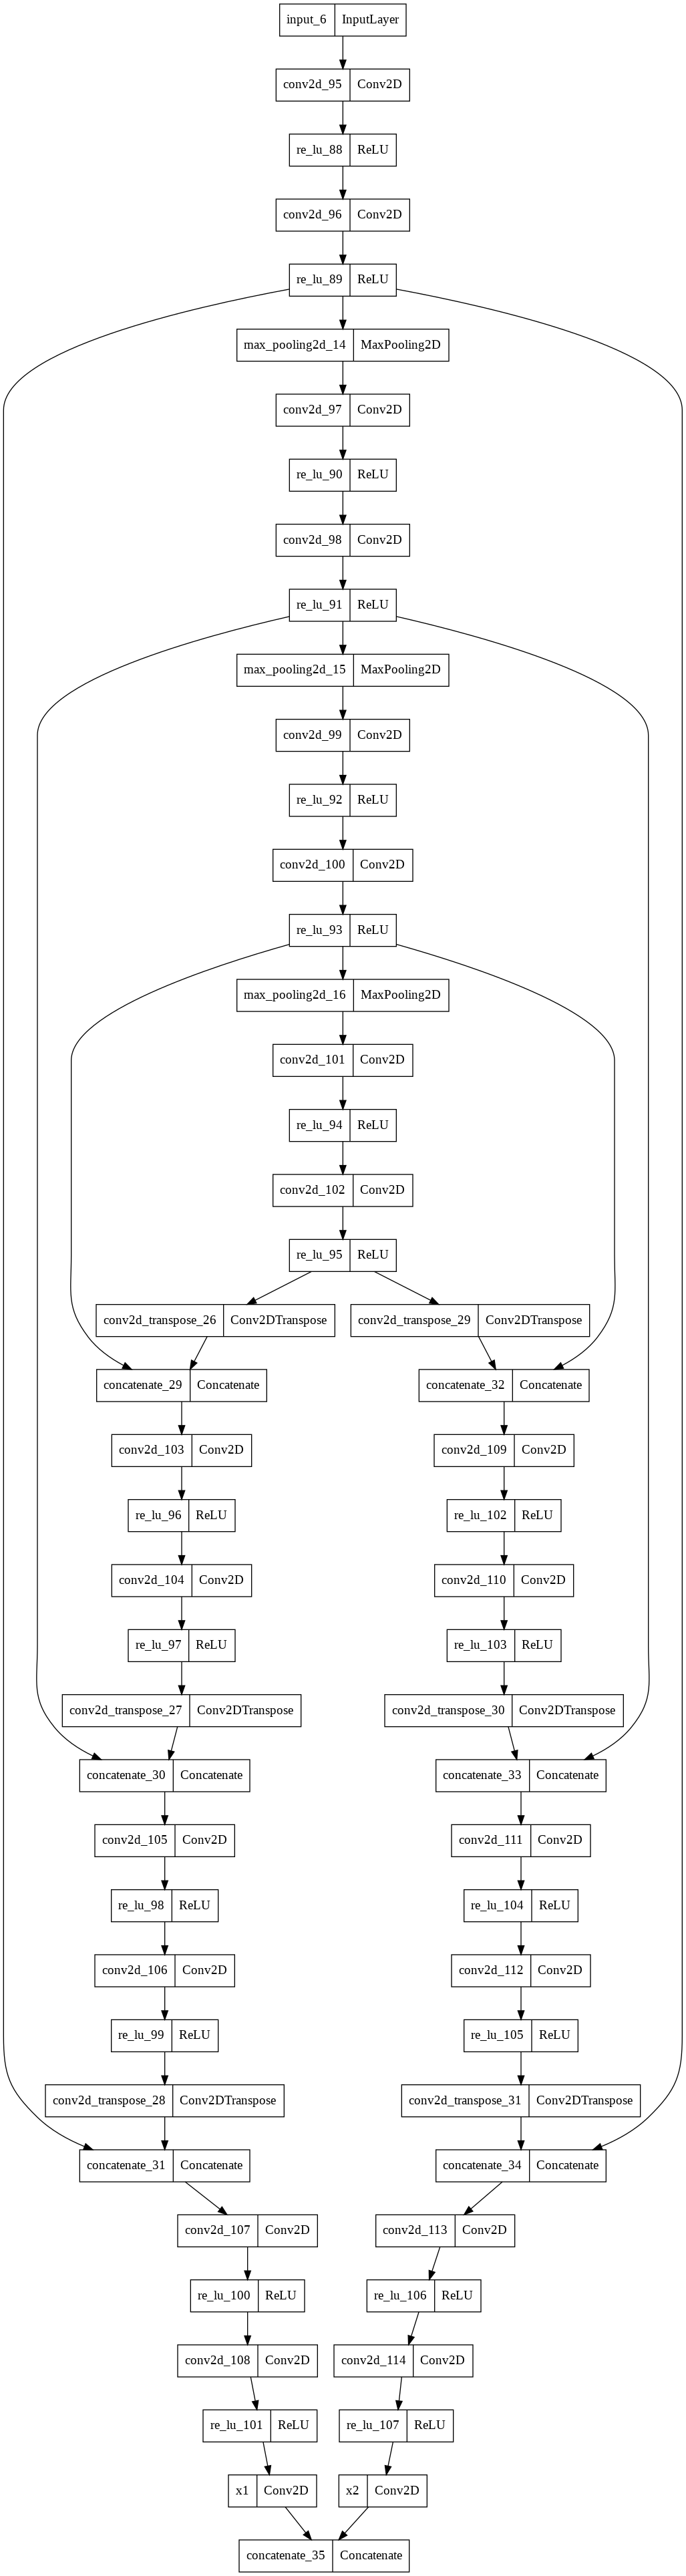

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(unet)

In [ ]:
hist = unet.fit(train_generator, epochs=50, batch_size=batchsize, validation_data=test_generator, callbacks=[callback_checkpoint,reduce_lr_callback],
              steps_per_epoch=steps_per_epoch, validation_steps=val_steps)

Epoch 1/50
937/937 [==============================] - 13s 13ms/step - loss: 0.0521 - val_loss: 0.0481 - lr: 0.0010
Epoch 2/50
937/937 [==============================] - 12s 13ms/step - loss: 0.0466 - val_loss: 0.0465 - lr: 0.0010
Epoch 3/50
937/937 [==============================] - 12s 12ms/step - loss: 0.0153 - val_loss: 0.0037 - lr: 0.0010
Epoch 4/50
937/937 [==============================] - 13s 14ms/step - loss: 0.0034 - val_loss: 0.0031 - lr: 0.0010
Epoch 5/50
937/937 [==============================] - 13s 14ms/step - loss: 0.0029 - val_loss: 0.0027 - lr: 0.0010
Epoch 6/50
937/937 [==============================] - 13s 13ms/step - loss: 0.0026 - val_loss: 0.0024 - lr: 0.0010
Epoch 7/50
937/937 [==============================] - 12s 12ms/step - loss: 0.0023 - val_loss: 0.0021 - lr: 0.0010
Epoch 8/50
937/937 [==============================] - 12s 13ms/step - loss: 0.0021 - val_loss: 0.0021 - lr: 0.0010
Epoch 9/50
937/937 [==============================] - 12s 13ms/step - loss: 0.00

In [ ]:
hist = unet.fit(train_generator, epochs=100, batch_size=batchsize, validation_data=test_generator, callbacks=[callback_checkpoint,reduce_lr_callback],
              steps_per_epoch=steps_per_epoch, validation_steps=val_steps)

Epoch 1/100
937/937 [==============================] - 12s 13ms/step - loss: 0.0010 - val_loss: 0.0010 - lr: 5.6314e-05
Epoch 2/100
937/937 [==============================] - 12s 12ms/step - loss: 0.0010 - val_loss: 0.0010 - lr: 5.6314e-05
Epoch 3/100
937/937 [==============================] - 12s 13ms/step - loss: 0.0010 - val_loss: 0.0010 - lr: 5.6314e-05
Epoch 4/100
935/937 [============================>.] - ETA: 0s - loss: 0.0010
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.223513315082528e-05.
937/937 [==============================] - 12s 13ms/step - loss: 0.0010 - val_loss: 0.0010 - lr: 5.6314e-05
Epoch 5/100
937/937 [==============================] - 12s 12ms/step - loss: 0.0010 - val_loss: 0.0010 - lr: 4.2235e-05
Epoch 6/100
937/937 [==============================] - 12s 12ms/step - loss: 0.0010 - val_loss: 0.0010 - lr: 4.2235e-05
Epoch 7/100
936/937 [============================>.] - ETA: 0s - loss: 0.0010
Epoch 7: ReduceLROnPlateau reducing learning rate to 3.16763

KeyboardInterrupt: ignored

In [ ]:
hist = unet.fit(train_generator, epochs=15, batch_size=batchsize, validation_data=test_generator, callbacks=[callback_checkpoint],
              steps_per_epoch=steps_per_epoch, validation_steps=val_steps)

Epoch 1/15
937/937 [==============================] - 41s 28ms/step - loss: 0.0520 - val_loss: 0.0472
Epoch 2/15
937/937 [==============================] - 27s 29ms/step - loss: 0.0455 - val_loss: 0.0460
Epoch 3/15
937/937 [==============================] - 27s 28ms/step - loss: 0.0449 - val_loss: 0.0453
Epoch 4/15
937/937 [==============================] - 26s 28ms/step - loss: 0.0446 - val_loss: 0.0452
Epoch 5/15
937/937 [==============================] - 26s 28ms/step - loss: 0.0444 - val_loss: 0.0450
Epoch 6/15
937/937 [==============================] - 26s 28ms/step - loss: 0.0442 - val_loss: 0.0448
Epoch 7/15
937/937 [==============================] - 27s 28ms/step - loss: 0.0441 - val_loss: 0.0450
Epoch 8/15
937/937 [==============================] - 26s 28ms/step - loss: 0.0440 - val_loss: 0.0446
Epoch 9/15
937/937 [==============================] - 26s 28ms/step - loss: 0.0441 - val_loss: 0.0448
Epoch 10/15
937/937 [==============================] - 27s 28ms/step - loss: 0.044

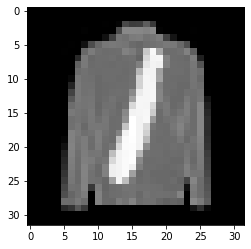

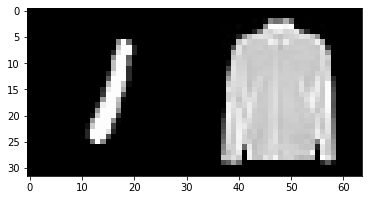

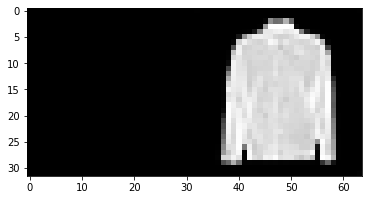

In [ ]:
x_batch, y_batch = next(test_generator)
x = x_batch[0]
y = y_batch[0]
y_pred = unet.predict(x.reshape((1,32,32)))
plt.imshow(x,cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(y, cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(y_pred[0].reshape((32,64)), cmap='gray', interpolation='nearest')
plt.show()

Again, using a custom loss

In [ ]:
unet = build_unet((32, 32, 1))

In [ ]:
unet.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d_88 (Conv2D)             (None, 32, 32, 32)   320         ['input_9[0][0]']                
                                                                                                  
 re_lu_88 (ReLU)                (None, 32, 32, 32)   0           ['conv2d_88[0][0]']              
                                                                                                  
 conv2d_89 (Conv2D)             (None, 32, 32, 32)   9248        ['re_lu_88[0][0]']               
                                                                                            

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, mean_squared_error
import numpy as np
import tensorflow as tf

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', min_lr=0.000009, min_delta=0.0001, factor=0.75, patience=3, verbose=1, mode='min')
callback_checkpoint = ModelCheckpoint('UNET_improved.{epoch:02d}-{val_loss:.4f}.hdf5', save_weights_only=True) 

In [ ]:
steps_per_epoch = N_train // batchsize
val_steps = N_test // batchsize

In [ ]:
val_steps

156

In [ ]:
def custom_loss(y_true, y_pred):
  return [MeanSquaredError()(y[:, :32], y_hat[:, :32]) if MeanSquaredError()(y[:, :32], y_hat[:, :32])>MeanSquaredError()(y[:, 32:], y_hat[:, 32:]) else MeanSquaredError()(y[:, 32:], y_hat[:, 32:]) for y, y_hat in zip(y_true, y_pred)]

In [ ]:
def custom_loss(y_true, y_pred):
  y1_batch = y_true[:, :, :32]
  y2_batch = y_true[:, :, 32:]
  y1_pred_batch = y_pred[:, :, :32]
  y2_pred_batch = y_pred[:, :, 32:]

  mse1_batch = tf.math.reduce_mean(mean_squared_error(y1_batch, y1_pred_batch), axis=-1)
  mse2_batch = tf.math.reduce_mean(mean_squared_error(y2_batch, y2_pred_batch), axis=-1)

  #res = np.maximum(mse1_batch, mse2_batch)
  #res = tf.math.maximum(mse1_batch, mse2_batch)
  #print(res.shape)
  #print(res)
  return tf.math.maximum(mse1_batch, mse2_batch)

In [ ]:
unet.compile(optimizer=Adam(), loss=custom_loss, metrics='mse', run_eagerly=True)

In [ ]:
from tensorflow.keras.losses import mean_squared_error
x_batch, y_batch = next(train_generator)


In [ ]:
hist = unet.fit(train_generator, epochs=15, batch_size=batchsize, validation_data=test_generator, callbacks=[callback_checkpoint,reduce_lr_callback],
              steps_per_epoch=steps_per_epoch, validation_steps=val_steps)

Epoch 1/15
937/937 [==============================] - 72s 77ms/step - loss: 0.0873 - mse: 0.0590 - val_loss: 0.0870 - val_mse: 0.0560 - lr: 0.0010
Epoch 2/15
937/937 [==============================] - 72s 77ms/step - loss: 0.0857 - mse: 0.0559 - val_loss: 0.0874 - val_mse: 0.0560 - lr: 0.0010
Epoch 3/15
937/937 [==============================] - 71s 76ms/step - loss: 0.0857 - mse: 0.0557 - val_loss: 0.0875 - val_mse: 0.0568 - lr: 0.0010
Epoch 4/15
937/937 [==============================] - 71s 76ms/step - loss: 0.0857 - mse: 0.0555 - val_loss: 0.0866 - val_mse: 0.0635 - lr: 0.0010
Epoch 5/15
937/937 [==============================] - 71s 76ms/step - loss: 0.0858 - mse: 0.0570 - val_loss: 0.0869 - val_mse: 0.0562 - lr: 0.0010
Epoch 6/15
937/937 [==============================] - 72s 77ms/step - loss: 0.0857 - mse: 0.0575 - val_loss: 0.0876 - val_mse: 0.0599 - lr: 0.0010
Epoch 7/15
937/937 [==============================] - ETA: 0s - loss: 0.0857 - mse: 0.0570
Epoch 7: ReduceLROnPlateau 

In [ ]:
hist = unet.fit(train_generator, epochs=15, batch_size=batchsize, validation_data=test_generator, callbacks=[callback_checkpoint,reduce_lr_callback],
              steps_per_epoch=steps_per_epoch, validation_steps=val_steps)

Epoch 1/15
10000/10000 [==============================] - 388s 39ms/step - loss: 0.0045 - mse: 0.0041 - val_loss: 0.0021 - val_mse: 0.0020 - lr: 0.0010
Epoch 2/15
10000/10000 [==============================] - 389s 39ms/step - loss: 0.0018 - mse: 0.0017 - val_loss: 0.0016 - val_mse: 0.0015 - lr: 0.0010
Epoch 3/15
 1500/10000 [===>..........................] - ETA: 5:27 - loss: 0.0016 - mse: 0.0015

KeyboardInterrupt: ignored

In [ ]:
hist = unet.fit(train_generator, epochs=15, batch_size=batchsize, validation_data=test_generator, callbacks=[callback_checkpoint,reduce_lr_callback],
              steps_per_epoch=steps_per_epoch, validation_steps=val_steps)

Epoch 1/15
937/937 [==============================] - 42s 44ms/step - loss: 0.0876 - mse: 0.0605 - val_loss: 0.0872 - val_mse: 0.0606 - lr: 0.0010
Epoch 2/15
937/937 [==============================] - 46s 50ms/step - loss: 0.0858 - mse: 0.0569 - val_loss: 0.0872 - val_mse: 0.0576 - lr: 0.0010
Epoch 3/15
937/937 [==============================] - 41s 44ms/step - loss: 0.0857 - mse: 0.0560 - val_loss: 0.0870 - val_mse: 0.0559 - lr: 0.0010
Epoch 4/15
937/937 [==============================] - 40s 43ms/step - loss: 0.0700 - mse: 0.0466 - val_loss: 0.0083 - val_mse: 0.0079 - lr: 0.0010
Epoch 5/15
937/937 [==============================] - 42s 45ms/step - loss: 0.0052 - mse: 0.0049 - val_loss: 0.0040 - val_mse: 0.0037 - lr: 0.0010
Epoch 6/15
937/937 [==============================] - 42s 45ms/step - loss: 0.0035 - mse: 0.0033 - val_loss: 0.0031 - val_mse: 0.0030 - lr: 0.0010
Epoch 7/15
937/937 [==============================] - 41s 43ms/step - loss: 0.0030 - mse: 0.0028 - val_loss: 0.0029 - 

In [ ]:
test_generator = datagenerator(mnist_x_test, fashion_mnist_x_test, 20000)
mse_list = []
for i in range(10):
  x_batch, y_batch = next(train_generator)
  mse = unet.evaluate(x_batch, y_batch)
  mse_list.append(mse)
print(mse_list)
print(np.mean(mse_list))
print(np.std(mse_list))

2/2 [==============================] - 0s 24ms/step - loss: 0.0018 - mse: 0.0017
[[0.001771446317434311, 0.0016973649617284536], [0.0015696545597165823, 0.0014612963423132896], [0.0020837830379605293, 0.0019664219580590725], [0.0018797898665070534, 0.001771413255482912], [0.0019334062235429883, 0.0018401257693767548], [0.0015733700711280107, 0.0014929352328181267], [0.001599424984306097, 0.0015245588729158044], [0.0016666203737258911, 0.001571053173393011], [0.0017470528837293386, 0.0016552231973037124], [0.001790559501387179, 0.001688511809334159]]
0.0017142006196081637
0.00016354740354676924


In [ ]:
import matplotlib.pyplot as plt
def plot_history(training_history, n_epochs=None):
    if not n_epochs:
      n_epochs = len(training_history.history['loss'])

    epochs = range(1,n_epochs+1)

    plt.plot(epochs, training_history.history['loss'], label='train_loss')
    plt.plot(epochs, training_history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.title('Loss')

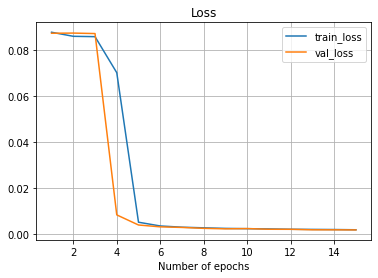

In [ ]:
plot_history(hist)

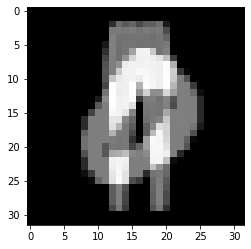

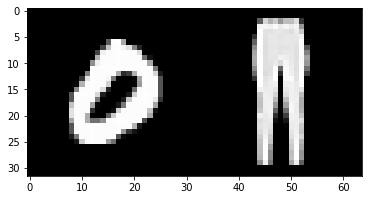

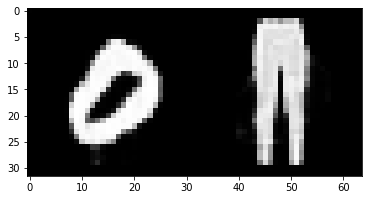

In [ ]:
x_batch, y_batch = next(test_generator)
x = x_batch[0]
y = y_batch[0]
y_pred = unet.predict(x.reshape((1,32,32)))
plt.imshow(x,cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(y, cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(y_pred[0].reshape((32,64)), cmap='gray', interpolation='nearest')
plt.show()

In [ ]:
def build_unet1(input_shape, n_ch=32, L=4, conv_per_L=2):
    x = Input(shape=input_shape)


    # DOWN
    backup_layers = []
    h = x
    for l in range(L):

        # Each floor in the descent phase
        for c in range(conv_per_L):
            h = Conv2D(n_ch, 3, 1, padding='same')(h)
            h = ReLU()(h)

        if l < L-1: # We don't want to downsample at the last level
            # Downsample
            backup_layers.append(h) # save for the skip connection 
            h = MaxPool2D(padding='same')(h)

            # Update the channels
            n_ch = n_ch * 2
    
    # UP (pay attention to do not double count the last level)
    for l in range(L-1):
        # Reduce the channels
        n_ch = n_ch // 2

        # Upsample
        h = Conv2DTranspose(n_ch, 3, 2, padding='same')(h)

        # Concatenate
        h = concatenate([h, backup_layers.pop(-1)])
        #h = concatenate([h, backup_layers1[-l-2]])

        # Each floor in the up phase
        for c in range(conv_per_L):
            h = Conv2D(n_ch, 3, 1, padding='same')(h)
            h = ReLU()(h)

    # Output
    x1 = Conv2D(1, 1, activation='sigmoid', name='x1')(h)


    # DOWN
    backup_layers = []
    h = x
    for l in range(L):

        # Each floor in the descent phase
        for c in range(conv_per_L):
            h = Conv2D(n_ch, 3, 1, padding='same')(h)
            h = ReLU()(h)

        if l < L-1: # We don't want to downsample at the last level
            # Downsample
            backup_layers.append(h) # save for the skip connection 
            h = MaxPool2D(padding='same')(h)

            # Update the channels
            n_ch = n_ch * 2
    
    # UP (pay attention to do not double count the last level)
    for l in range(L-1):
        # Reduce the channels
        n_ch = n_ch // 2

        # Upsample
        h = Conv2DTranspose(n_ch, 3, 2, padding='same')(h)

        # Concatenate
        h = concatenate([h, backup_layers.pop(-1)])
        #h = concatenate([h, backup_layers1[-l-2]])

        # Each floor in the up phase
        for c in range(conv_per_L):
            h = Conv2D(n_ch, 3, 1, padding='same')(h)
            h = ReLU()(h)

    # Output
    x2 = Conv2D(1, 1, activation='sigmoid', name='x2')(h)


    y = concatenate([x1,x2], axis=2)
    #y = Concatenate(axis=2)([x1,x2])

    return Model(x, y)

In [ ]:
unet = build_unet1((32, 32, 1))

In [ ]:
unet.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d_249 (Conv2D)            (None, 32, 32, 32)   320         ['input_16[0][0]']               
                                                                                                  
 conv2d_263 (Conv2D)            (None, 32, 32, 32)   320         ['input_16[0][0]']               
                                                                                                  
 re_lu_242 (ReLU)               (None, 32, 32, 32)   0           ['conv2d_249[0][0]']             
                                                                                            

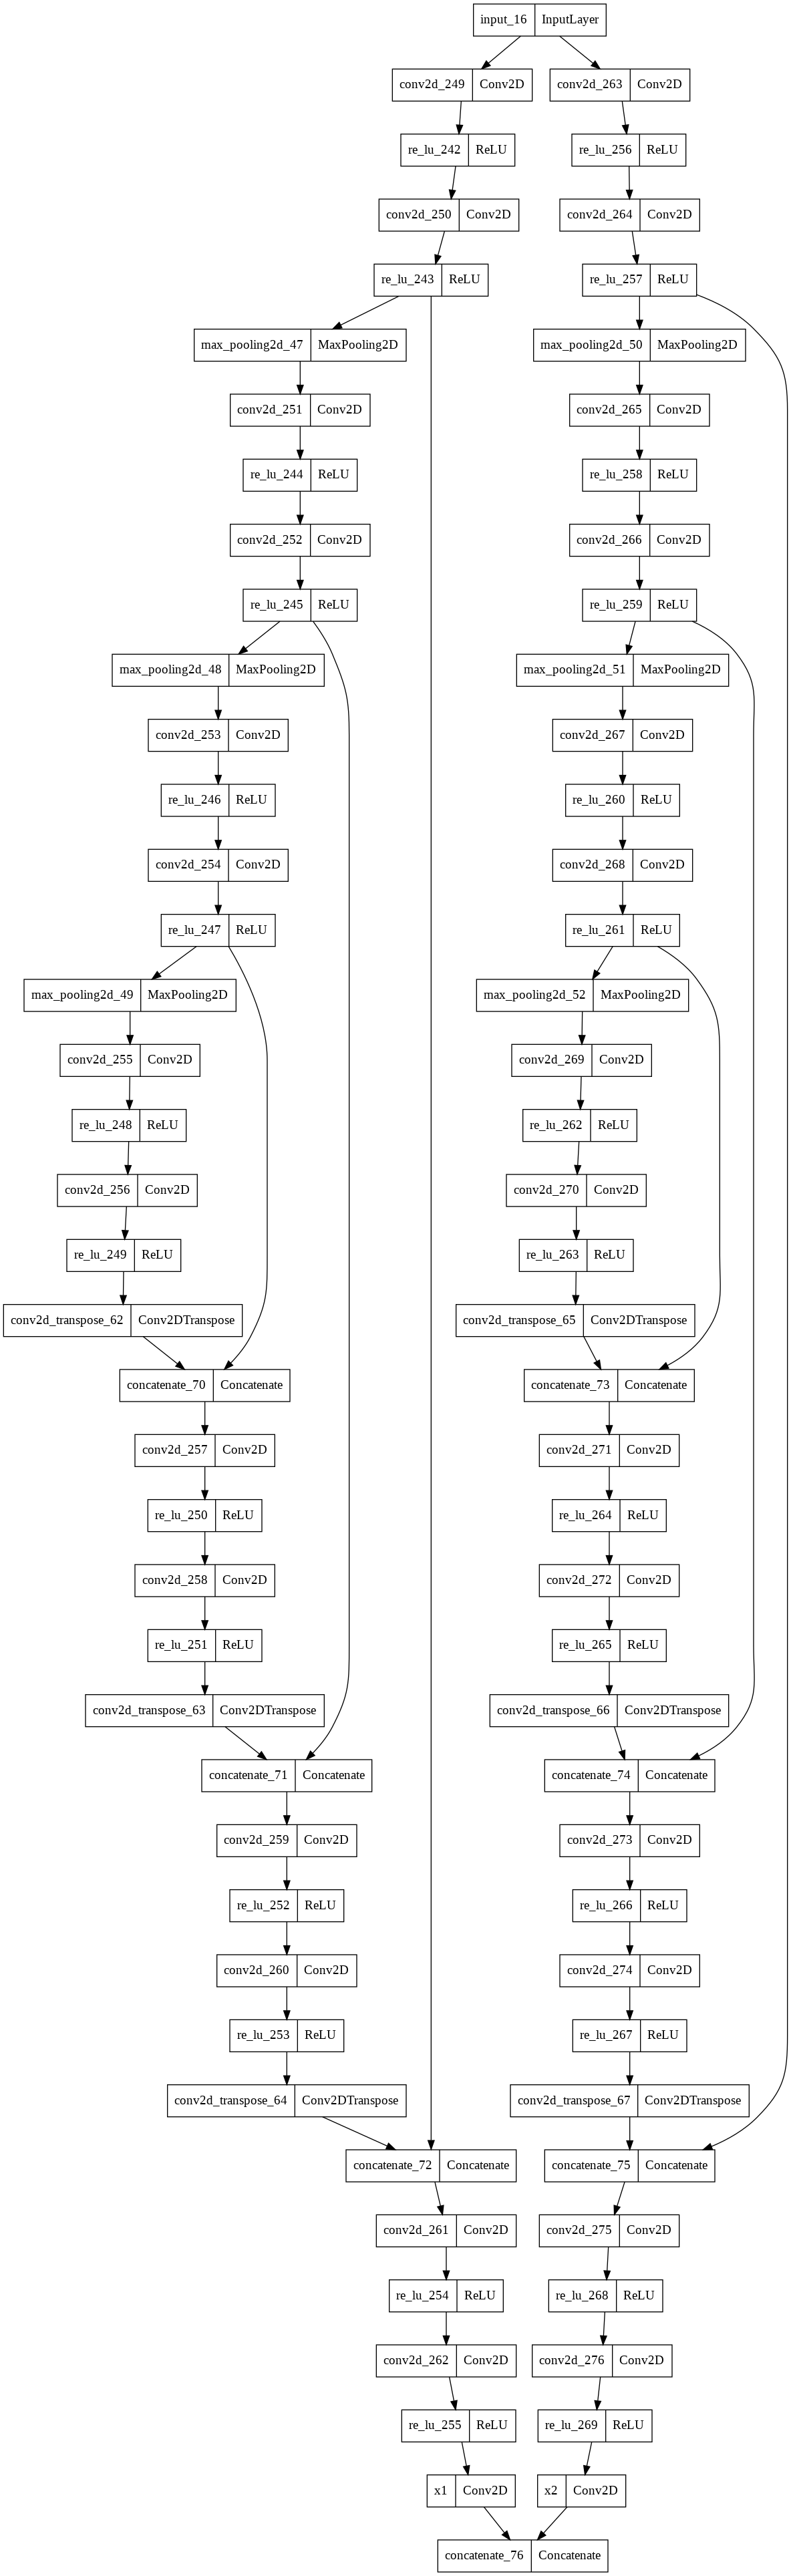

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(unet)

In [ ]:
from tensorflow.keras.optimizers import Adam

In [ ]:
unet.compile(optimizer=Adam(), loss='mse')

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

callback_checkpoint = ModelCheckpoint('UNET_improved1.{epoch:02d}-{val_loss:.4f}.hdf5', save_weights_only=True) 

In [ ]:
steps_per_epoch = N_train // batchsize
val_steps = N_test // batchsize

In [ ]:
hist = unet.fit(train_generator, epochs=15, batch_size=batchsize, validation_data=test_generator, callbacks=[callback_checkpoint],
              steps_per_epoch=steps_per_epoch, validation_steps=val_steps)

Epoch 1/15
937/937 [==============================] - 45s 46ms/step - loss: 0.0479 - val_loss: 0.0453
Epoch 2/15
937/937 [==============================] - 41s 44ms/step - loss: 0.0439 - val_loss: 0.0444
Epoch 3/15
937/937 [==============================] - 42s 45ms/step - loss: 0.0438 - val_loss: 0.0443
Epoch 4/15
937/937 [==============================] - 41s 44ms/step - loss: 0.0436 - val_loss: 0.0443
Epoch 5/15
937/937 [==============================] - 42s 44ms/step - loss: 0.0435 - val_loss: 0.0445
Epoch 6/15
937/937 [==============================] - 42s 44ms/step - loss: 0.0435 - val_loss: 0.0438
Epoch 7/15
343/937 [=========>....................] - ETA: 24s - loss: 0.0436

KeyboardInterrupt: ignored

In [ ]:
hist = unet.fit(train_generator, epochs=15, batch_size=batchsize, validation_data=test_generator, callbacks=[callback_checkpoint],
              steps_per_epoch=steps_per_epoch, validation_steps=val_steps)

Epoch 1/15
937/937 [==============================] - 41s 28ms/step - loss: 0.0520 - val_loss: 0.0472
Epoch 2/15
937/937 [==============================] - 27s 29ms/step - loss: 0.0455 - val_loss: 0.0460
Epoch 3/15
937/937 [==============================] - 27s 28ms/step - loss: 0.0449 - val_loss: 0.0453
Epoch 4/15
937/937 [==============================] - 26s 28ms/step - loss: 0.0446 - val_loss: 0.0452
Epoch 5/15
937/937 [==============================] - 26s 28ms/step - loss: 0.0444 - val_loss: 0.0450
Epoch 6/15
937/937 [==============================] - 26s 28ms/step - loss: 0.0442 - val_loss: 0.0448
Epoch 7/15
937/937 [==============================] - 27s 28ms/step - loss: 0.0441 - val_loss: 0.0450
Epoch 8/15
937/937 [==============================] - 26s 28ms/step - loss: 0.0440 - val_loss: 0.0446
Epoch 9/15
937/937 [==============================] - 26s 28ms/step - loss: 0.0441 - val_loss: 0.0448
Epoch 10/15
937/937 [==============================] - 27s 28ms/step - loss: 0.044

In [ ]:
import matplotlib.pyplot as plt
def plot_history(training_history, n_epochs=None):
    if not n_epochs:
      n_epochs = len(training_history.history['loss'])

    epochs = range(1,n_epochs+1)

    plt.plot(epochs, training_history.history['loss'], label='train_loss')
    plt.plot(epochs, training_history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.title('Loss')

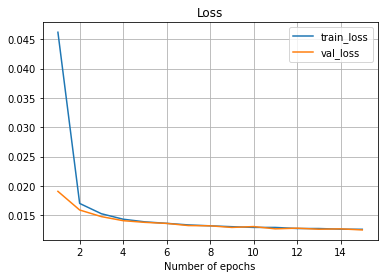

In [ ]:
plot_history(hist)

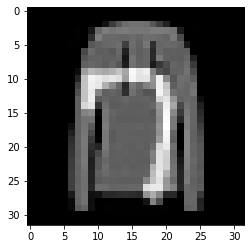

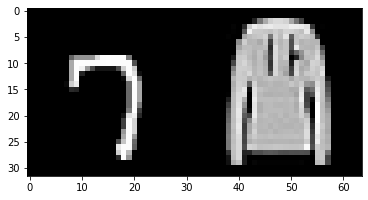

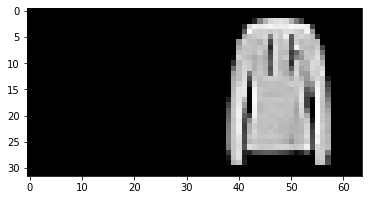

In [ ]:
x_batch, y_batch = next(test_generator)
x = x_batch[0]
y = y_batch[0]
y_pred = unet.predict(x.reshape((1,32,32)))
plt.imshow(x,cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(y, cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(y_pred[0].reshape((32,64)), cmap='gray', interpolation='nearest')
plt.show()

In [ ]:
def build_unet(input, n_ch=32, L=4, conv_per_L=2):
    x = input

    # DOWN
    backup_layers = []
    h = x
    for l in range(L):

        # Each floor in the descent phase
        for c in range(conv_per_L):
            h = Conv2D(n_ch, 3, 1, padding='same')(h)
            h = ReLU()(h)

        if l < L-1: # We don't want to downsample at the last level
            # Downsample
            backup_layers.append(h) # save for the skip connection 
            h = MaxPool2D(padding='same')(h)

            # Update the channels
            n_ch = n_ch * 2
    
    # UP (pay attention to do not double count the last level)
    for l in range(L-1):
        # Reduce the channels
        n_ch = n_ch // 2

        # Upsample
        h = Conv2DTranspose(n_ch, 3, 2, padding='same')(h)

        # Concatenate
        h = concatenate([h, backup_layers.pop(-1)])

        # Each floor in the up phase
        for c in range(conv_per_L):
            h = Conv2D(n_ch, 3, 1, padding='same')(h)
            h = ReLU()(h)
        
    # Output
    y = Conv2D(1, 1, activation='sigmoid')(h)
    return y

In [ ]:
x = Input(shape=(32,32,1))
x1 = build_unet(input=x)
x2 = build_unet(input=x)
y = Concatenate(axis=2)([x1,x2])

model = Model(x, y)

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d_31 (Conv2D)             (None, 32, 32, 32)   320         ['input_5[0][0]']                
                                                                                                  
 conv2d_46 (Conv2D)             (None, 32, 32, 32)   320         ['input_5[0][0]']                
                                                                                                  
 re_lu_28 (ReLU)                (None, 32, 32, 32)   0           ['conv2d_31[0][0]']              
                                                                                            

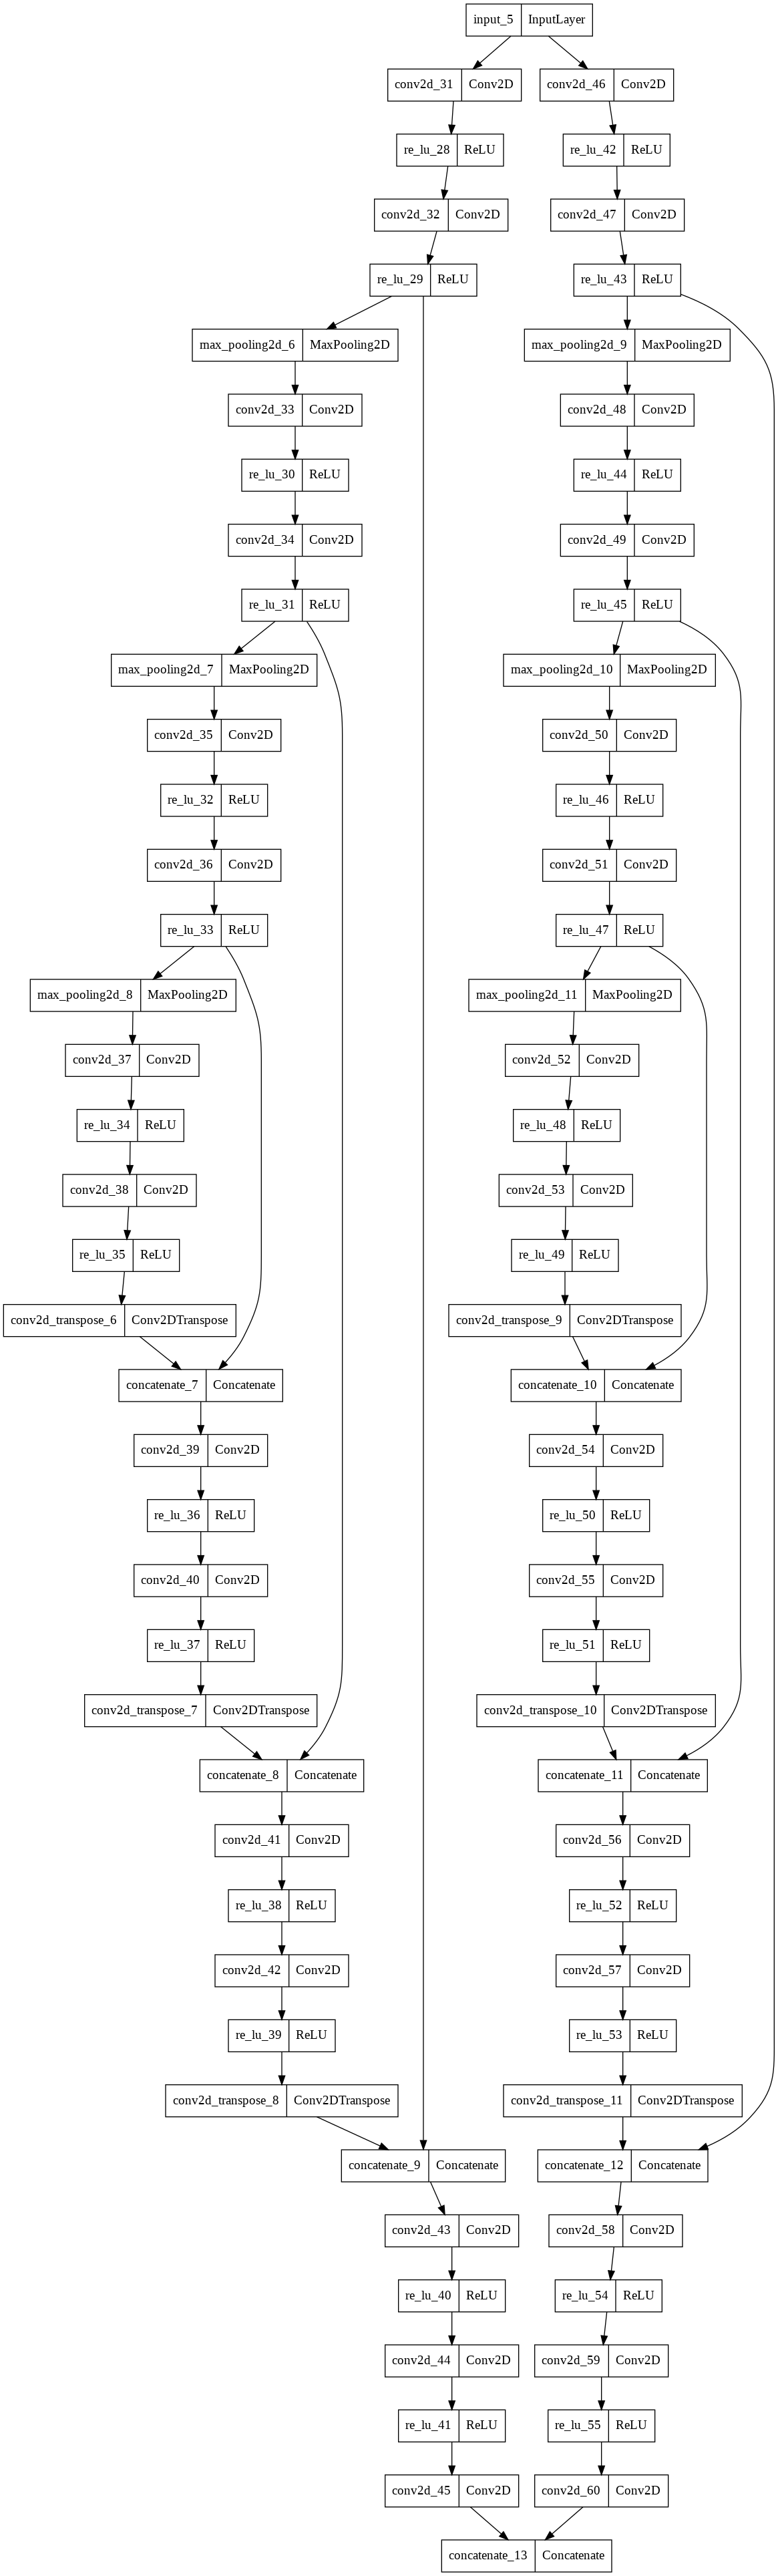

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [ ]:
from tensorflow.keras.optimizers import Adam

In [ ]:
model.compile(optimizer=Adam(), loss='mse')

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

callback_checkpoint = ModelCheckpoint('UNET_improved1.{epoch:02d}-{val_loss:.4f}.hdf5', save_weights_only=True) 

In [ ]:
steps_per_epoch = N_train // batchsize
val_steps = N_test // batchsize

In [ ]:
hist = model.fit(train_generator, epochs=15, batch_size=batchsize, validation_data=test_generator, callbacks=[callback_checkpoint],
                 steps_per_epoch=steps_per_epoch, validation_steps=val_steps)

Epoch 1/15
937/937 [==============================] - 54s 42ms/step - loss: 0.0474 - val_loss: 0.0449
Epoch 2/15
937/937 [==============================] - 39s 42ms/step - loss: 0.0440 - val_loss: 0.0444
Epoch 3/15
119/937 [==>...........................] - ETA: 32s - loss: 0.0437

KeyboardInterrupt: ignored

In [ ]:
hist = unet.fit(train_generator, epochs=15, batch_size=batchsize, validation_data=test_generator, callbacks=[callback_checkpoint],
              steps_per_epoch=steps_per_epoch, validation_steps=val_steps)

Epoch 1/15
937/937 [==============================] - 41s 28ms/step - loss: 0.0520 - val_loss: 0.0472
Epoch 2/15
937/937 [==============================] - 27s 29ms/step - loss: 0.0455 - val_loss: 0.0460
Epoch 3/15
937/937 [==============================] - 27s 28ms/step - loss: 0.0449 - val_loss: 0.0453
Epoch 4/15
937/937 [==============================] - 26s 28ms/step - loss: 0.0446 - val_loss: 0.0452
Epoch 5/15
937/937 [==============================] - 26s 28ms/step - loss: 0.0444 - val_loss: 0.0450
Epoch 6/15
937/937 [==============================] - 26s 28ms/step - loss: 0.0442 - val_loss: 0.0448
Epoch 7/15
937/937 [==============================] - 27s 28ms/step - loss: 0.0441 - val_loss: 0.0450
Epoch 8/15
937/937 [==============================] - 26s 28ms/step - loss: 0.0440 - val_loss: 0.0446
Epoch 9/15
937/937 [==============================] - 26s 28ms/step - loss: 0.0441 - val_loss: 0.0448
Epoch 10/15
937/937 [==============================] - 27s 28ms/step - loss: 0.044

In [ ]:
import matplotlib.pyplot as plt
def plot_history(training_history, n_epochs=None):
    if not n_epochs:
      n_epochs = len(training_history.history['loss'])

    epochs = range(1,n_epochs+1)

    plt.plot(epochs, training_history.history['loss'], label='train_loss')
    plt.plot(epochs, training_history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.title('Loss')

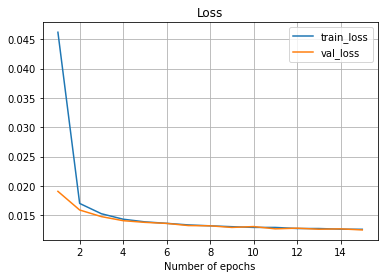

In [ ]:
plot_history(hist)

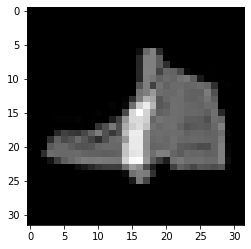

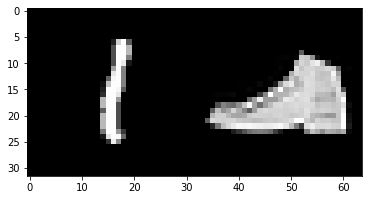

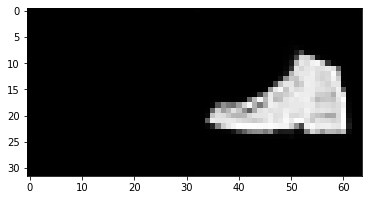

In [ ]:
x_batch, y_batch = next(test_generator)
x = x_batch[0]
y = y_batch[0]
y_pred = model.predict(x.reshape((1,32,32)))
plt.imshow(x,cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(y, cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(y_pred[0].reshape((32,64)), cmap='gray', interpolation='nearest')
plt.show()

In [ ]:
def build_unet(input, n_ch=32, L=4, conv_per_L=2):
    x = input

    # DOWN
    backup_layers = []
    h = x
    for l in range(L):

        # Each floor in the descent phase
        for c in range(conv_per_L):
            h = Conv2D(n_ch, 3, 1, padding='same')(h)
            h = ReLU()(h)

        if l < L-1: # We don't want to downsample at the last level
            # Downsample
            backup_layers.append(h) # save for the skip connection 
            h = MaxPool2D(padding='same')(h)

            # Update the channels
            n_ch = n_ch * 2
    
    # UP (pay attention to do not double count the last level)
    for l in range(L-1):
        # Reduce the channels
        n_ch = n_ch // 2

        # Upsample
        h = Conv2DTranspose(n_ch, 3, 2, padding='same')(h)

        # Concatenate
        h = concatenate([h, backup_layers.pop(-1)])

        # Each floor in the up phase
        for c in range(conv_per_L):
            h = Conv2D(n_ch, 3, 1, padding='same')(h)
            h = ReLU()(h)
        
    # Output
    y = Conv2D(1, 1, activation='sigmoid')(h)
    return y

In [ ]:
x = Input(shape=(32,32,1))
x1 = build_unet(input=x, n_ch=16, L=2, conv_per_L=1)
x2 = build_unet(input=x, n_ch=16, L=2, conv_per_L=1)
y = Concatenate(axis=2)([x1,x2])

model = Model(x, y)

In [ ]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d_44 (Conv2D)             (None, 32, 32, 16)   160         ['input_7[0][0]']                
                                                                                                  
 conv2d_48 (Conv2D)             (None, 32, 32, 16)   160         ['input_7[0][0]']                
                                                                                                  
 re_lu_34 (ReLU)                (None, 32, 32, 16)   0           ['conv2d_44[0][0]']              
                                                                                            

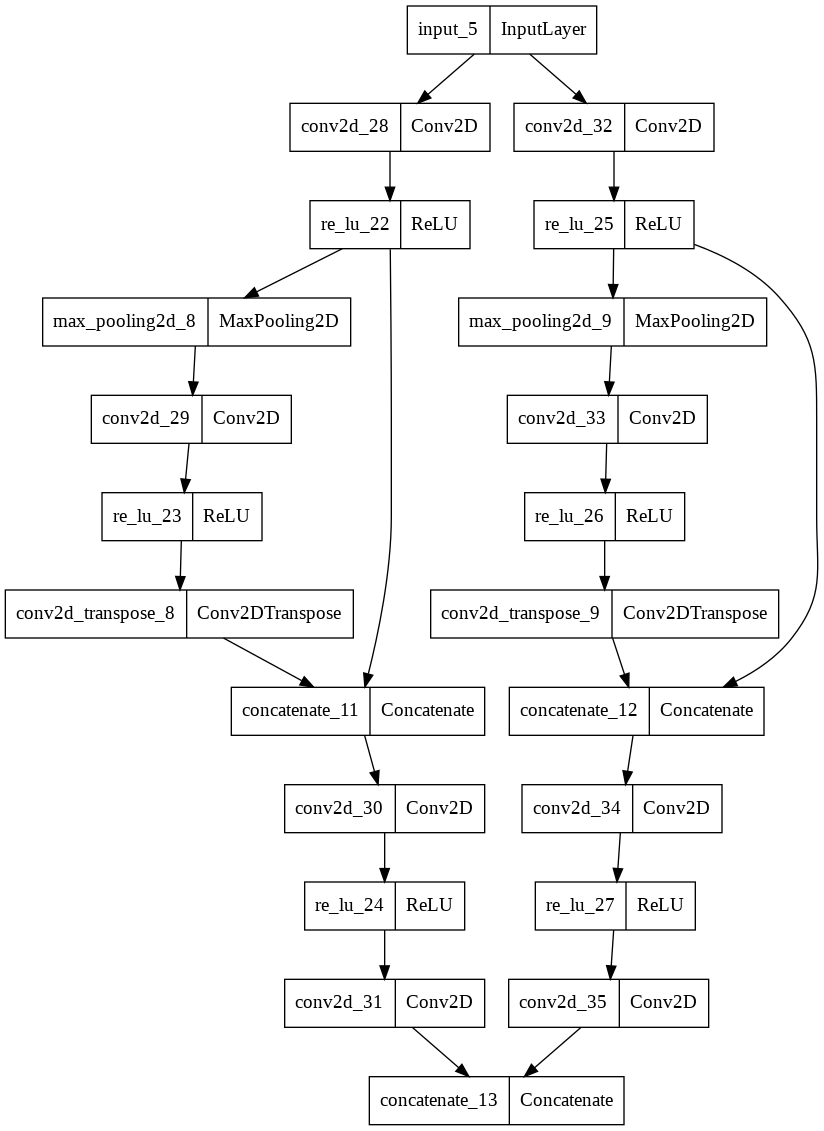

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [ ]:
from tensorflow.keras.optimizers import Adam

In [ ]:
model.compile(optimizer=Adam(), loss='mse')

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

callback_checkpoint = ModelCheckpoint('UNET_basic.{epoch:02d}-{val_loss:.4f}.hdf5', save_weights_only=True) 

In [ ]:
steps_per_epoch = 10000
val_steps = N_test // batchsize

In [ ]:
hist = model.fit(train_generator, epochs=15, batch_size=batchsize, validation_data=test_generator, callbacks=[callback_checkpoint],
                 steps_per_epoch=steps_per_epoch, validation_steps=val_steps)

Epoch 1/15
10000/10000 [==============================] - 98s 10ms/step - loss: 0.0472 - val_loss: 0.0462
Epoch 2/15
 1504/10000 [===>..........................] - ETA: 1:21 - loss: 0.0453

KeyboardInterrupt: ignored

In [ ]:
hist = unet.fit(train_generator, epochs=15, batch_size=batchsize, validation_data=test_generator, callbacks=[callback_checkpoint],
              steps_per_epoch=steps_per_epoch, validation_steps=val_steps)

Epoch 1/15
937/937 [==============================] - 41s 28ms/step - loss: 0.0520 - val_loss: 0.0472
Epoch 2/15
937/937 [==============================] - 27s 29ms/step - loss: 0.0455 - val_loss: 0.0460
Epoch 3/15
937/937 [==============================] - 27s 28ms/step - loss: 0.0449 - val_loss: 0.0453
Epoch 4/15
937/937 [==============================] - 26s 28ms/step - loss: 0.0446 - val_loss: 0.0452
Epoch 5/15
937/937 [==============================] - 26s 28ms/step - loss: 0.0444 - val_loss: 0.0450
Epoch 6/15
937/937 [==============================] - 26s 28ms/step - loss: 0.0442 - val_loss: 0.0448
Epoch 7/15
937/937 [==============================] - 27s 28ms/step - loss: 0.0441 - val_loss: 0.0450
Epoch 8/15
937/937 [==============================] - 26s 28ms/step - loss: 0.0440 - val_loss: 0.0446
Epoch 9/15
937/937 [==============================] - 26s 28ms/step - loss: 0.0441 - val_loss: 0.0448
Epoch 10/15
937/937 [==============================] - 27s 28ms/step - loss: 0.044

In [ ]:
import matplotlib.pyplot as plt
def plot_history(training_history, n_epochs=None):
    if not n_epochs:
      n_epochs = len(training_history.history['loss'])

    epochs = range(1,n_epochs+1)

    plt.plot(epochs, training_history.history['loss'], label='train_loss')
    plt.plot(epochs, training_history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.title('Loss')

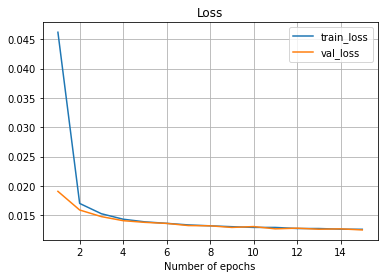

In [ ]:
plot_history(hist)

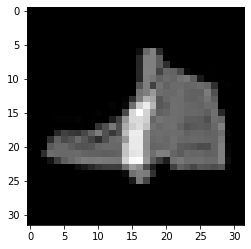

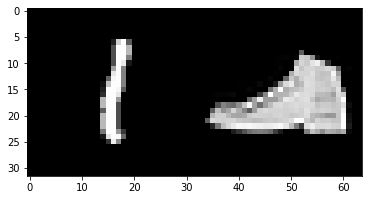

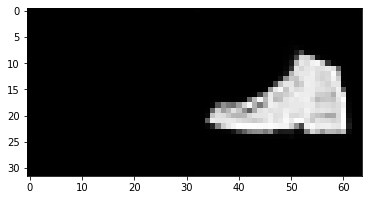

In [ ]:
x_batch, y_batch = next(test_generator)
x = x_batch[0]
y = y_batch[0]
y_pred = model.predict(x.reshape((1,32,32)))
plt.imshow(x,cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(y, cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(y_pred[0].reshape((32,64)), cmap='gray', interpolation='nearest')
plt.show()